In [1]:
# Objective: Using tensorflow-constrained-optimizaiton library to obtains a mixture of Gaussian which approximates a given cactus distribution.
# Last Update: 11/29/2021 by Fei

In [5]:
### import math
import numpy as np
import pandas as pd
from six.moves import xrange
import tensorflow as tf
import tensorflow_probability as tfp
import csv
import tensorflow_constrained_optimization as tfco
import math as m

# set parameters
sen = 1
variance = 2

mixture_number = 9
r = 0.9
iter_num = 2600
learning_rate = 0.003

# Load cactus distribution files

filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
cactus_x = np.genfromtxt(filename, dtype=np.float32)
cactus_x = cactus_x.reshape([len(cactus_x),1])
tf_x = tf.constant(cactus_x)

N = len(cactus_x)
print('total sample number N = ',N)

xmax = max(cactus_x)
print('maximum range xmax = ',xmax)

n = N//xmax//2
print('quantization rate n = ',n)

filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
cactus_pdf = np.genfromtxt(filename, dtype=np.float32)*n
cactus_pdf = cactus_pdf.reshape([len(cactus_pdf),1])
tf_pdf = tf.constant(cactus_pdf)


tf.print("Initialization...")

# Create variables containing the model parameters.

mu = tf.Variable([np.linspace(-4*np.sqrt(variance),4*np.sqrt(variance),mixture_number)], dtype=tf.float32, name="mu")
tf.print("mu=",mu)

sigma = tf.Variable(tf.ones([1,mixture_number]), dtype=tf.float32, name="sigma")
tf.print("sigma=",sigma)

weights = tf.Variable([[1/mixture_number]*mixture_number], dtype=tf.float32, name="weights")
tf.print("weight=",weights)

# define the loss function

@tf.function
def loss_fn():
  pred = 1/tf.sqrt(2*np.pi)/sigma*tf.exp(-tf.square(tf_x-mu)/2/tf.square(sigma))
  newpdf = tf.matmul(pred, tf.transpose(weights/tf.reduce_sum(weights)))

  temp = tf.reduce_sum(tf.square(newpdf-tf_pdf))
  return temp

# define the optimization problem

class ExampleProblem(tfco.ConstrainedMinimizationProblem):

  def __init__(self, labels, weights):
    self._labels = labels
    self._weights = weights

  @property
  def num_constraints(self):
    return 2+mixture_number

  def objective(self):
    return loss_fn()

  def constraints(self):
    weights = self._weights
    wp = tf.reduce_sum(weights) - tf.ones([1,1])
    wn = tf.ones([1,1]) - tf.reduce_sum(weights)
    return tf.concat([wp, wn, -weights],axis=1)

# Initialize the optimization problem

problem = ExampleProblem(
    labels=cactus_pdf,
    weights=weights,)

# Initialize the training setup

if tf.executing_eagerly():
  optimizer = tfco.LagrangianOptimizer(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    num_constraints=problem.num_constraints)
 
  # Define a list of trainable variables

  var_list = ([mu,sigma,weights] + list(problem.trainable_variables) +
                optimizer.trainable_variables())
    
  tf.print("start training...")
  
  for ii in xrange(iter_num):
    optimizer.minimize(problem, var_list=var_list)
    if ii%100==0:
      tf.print("round=",ii, 'loss =',loss_fn())

  tf.print("training completed.")
  
  mu_np = mu.numpy()
  sigma_np = sigma.numpy()
  weights_np = (weights/tf.reduce_sum(weights)).numpy()

  filename = ('privacy_data/mix_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
  np.savetxt(filename, np.stack((mu_np.reshape(-1), sigma_np.reshape(-1), weights_np.reshape(-1))), delimiter=',')
  print("result saved.")
  

total sample number N =  5657
maximum range xmax =  [14.138]
quantization rate n =  [200.]
Initialization...
mu= [[-5.65685415 -5.09116888 -4.52548361 ... 4.52548361 5.09116888 5.65685415]]
sigma= [[1 1 1 ... 1 1 1]]
weight= [[0.0476190485 0.0476190485 0.0476190485 ... 0.0476190485 0.0476190485 0.0476190485]]
start training...
round= 0 loss = 17.9570274
round= 100 loss = 0.016252242
round= 200 loss = 0.0158476923
round= 300 loss = 0.0161442757
round= 400 loss = 0.0166375265
round= 500 loss = 0.0160043761
round= 600 loss = 0.0167081896
round= 700 loss = 0.0156325828
round= 800 loss = 0.0167366154
round= 900 loss = 0.0156217907
round= 1000 loss = 0.0166255422
round= 1100 loss = 0.0156959519
round= 1200 loss = 0.0158565547
round= 1300 loss = 0.0170837156
round= 1400 loss = 0.0155937783
round= 1500 loss = 0.0168575756
round= 1600 loss = 0.015770752
round= 1700 loss = 0.0158147085
round= 1800 loss = 0.016141057
round= 1900 loss = 0.0160780661
round= 2000 loss = 0.0157641172
round= 2100 loss

total sample number N =  5657
maximum range xmax =  [14.138]
quantization rate n =  [200.]
mixture number is 21
mu =  [-5.7242241e+00 -5.1659493e+00 -4.5776925e+00 -3.8575113e+00
 -3.2876344e+00 -2.7005081e+00 -2.1739211e+00 -1.6287943e+00
 -1.0769937e+00 -4.9026400e-01 -2.0910557e-03  4.9065706e-01
  1.0770264e+00  1.6282052e+00  2.1731620e+00  2.7001636e+00
  3.2888482e+00  3.8558466e+00  4.5769033e+00  5.1680942e+00
  5.7239995e+00]
sigma =  [1.0595621  1.1394327  1.1015754  1.0905584  1.0811862  1.0635215
 1.0807767  1.0253708  1.018999   0.9474284  0.91744906 0.9477366
 1.0180681  1.0243404  1.0801044  1.0637747  1.082061   1.0899092
 1.0991799  1.1395853  1.062469  ]
weights =  [-0.01495422  0.02643248 -0.01223651  0.00234017  0.00123578  0.00323713
  0.00594818  0.07600415  0.155874    0.16960151  0.17393178  0.16977061
  0.15547861  0.07543855  0.00578969  0.00285901  0.00117574  0.00366639
 -0.01318261  0.02612284 -0.01453337]
sum of weights is 1.0


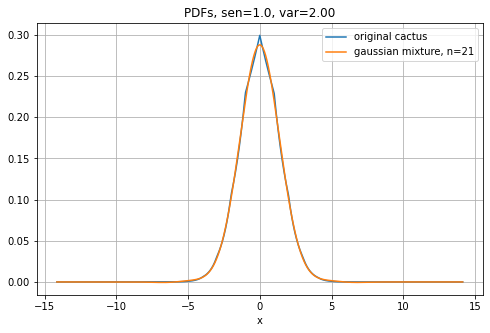

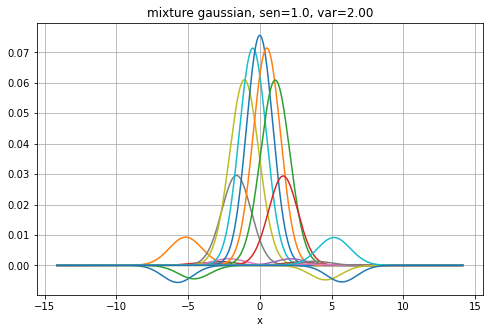

In [6]:
# we plot the obtained pdfs.

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity

# set parameters

sen = 1
variance = 2
mixture_number = 21

# Load cactus distribution files

filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
cactus_x = np.genfromtxt(filename, dtype=np.float32)
cactus_x = cactus_x.reshape([len(cactus_x),1])

N = len(cactus_x)
print('total sample number N = ',N)

xmax = max(cactus_x)
print('maximum range xmax = ',xmax)

n = N//xmax//2
print('quantization rate n = ',n)

filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
cactus_pdf = np.genfromtxt(filename, dtype=np.float32)*n
cactus_pdf = cactus_pdf.reshape([len(cactus_pdf),1])

# Load mixture gaussian approximation of the cactus above

filename = ('privacy_data/mix_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
[mu_np,sigma_np,weights_np] = np.genfromtxt(filename, dtype=np.float32,delimiter=',')
print("mixture number is", mixture_number)
print("mu = ", mu_np)
print("sigma = ", sigma_np)
print("weights = ", weights_np)

mu_np = mu_np.reshape((1,mixture_number))
sigma_np = sigma_np.reshape((1,mixture_number))
weights_np = weights_np.reshape((1,mixture_number))
w = np.sum(weights_np)
weights_np = weights_np/w
print("sum of weights is", np.sum(weights_np))

# this is the optimization-obtained mixture gaussian pdf

opt_pdf =np.matmul(1/np.sqrt(2*np.pi)/sigma_np*np.exp(-np.square(cactus_x-mu_np)/2/np.square(sigma_np)),np.transpose(weights_np))


# this is the elements of the mixture gaussian pdf

mix_pdf=[]
for i in range(mixture_number):
    temp = 1/np.sqrt(2*np.pi)/sigma_np[0][i]*np.exp(-np.square(cactus_x-mu_np[0][i])/2/np.square(sigma_np[0][i]))*weights_np[0][i]
    mix_pdf.append(temp)

# this is the kernel density estimation of cactus from sample pool

filename = ('privacy_data/cactus_samples_d%1.1f_v%1.2f.npy' %(sen, variance))
samples=np.load(filename)
den_kernel = gaussian_kde(samples)

# PLOTS

# original/kernel density/gassian mixture
plt.figure(figsize=(8, 5))
plt.plot(cactus_x,cactus_pdf, label=('original cactus'))
# plt.plot(cactus_x,2*den_kernel.pdf(np.transpose(cactus_x)), label=('kernel density'))
plt.plot(cactus_x,opt_pdf, label=('gaussian mixture, n=%d' %(mixture_number)))
plt.xlabel('x')
plt.title('PDFs, sen=%1.1f, var=%.2f' %(sen, variance))
plt.legend()
plt.grid(True)


# each element pdf of the gaussian mixture
plt.figure(figsize=(8, 5))
for i in range(mixture_number):
    plt.plot(cactus_x, mix_pdf[i])
plt.xlabel('x')
plt.title('mixture gaussian, sen=%1.1f, var=%.2f' %(sen, variance))
plt.grid(True)

In [ ]:
# This is a testcase

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
mu_test=np.array([-2,0,2]).reshape(1,3)
sigma_test = np.array([1,1,1]).reshape(1,3)
weights_test = np.array([1/3,1/3,1/3]).reshape(1,3)
x_grid = np.linspace(-8,8,100).reshape(100,1)
mix_num = 3

opt_pdf =np.matmul(1/np.sqrt(2*np.pi)/sigma_test*np.exp(-np.square(x_grid-mu_test)/2/np.square(sigma_test)),np.transpose(weights_test))


mix_pdf=[]
for i in range(mix_num):
    temp = 1/np.sqrt(2*np.pi)/sigma_test[0][i]*np.exp(-np.square(x_grid-mu_test[0][i])/2/np.square(sigma_test[0][i]))*weights_test[0][i]
    mix_pdf.append(temp)

mu_total = 0
sigma_total = 1/3
total_pdf = 1/np.sqrt(2*np.pi)/sigma_total*np.exp(-np.square(x_grid-mu_total)/2/np.square(sigma_total))
    
plt.figure(figsize=(8, 5))

for i in range(mix_num):
    plt.plot(x_grid, mix_pdf[i], label=('#%d' %(i)))
plt.plot(x_grid,opt_pdf,label=('mixture'))
plt.plot(x_grid,total_pdf,label=('total'))
plt.xlabel('x')
plt.legend()
plt.grid(True)